Repository from where the "utils.py" lib was adapted: [here](https://github.com/vandedok/IIC_tutorial)\
Repository of the original paper: [here](https://github.com/xu-ji/IIC)\
ChatGPT [here](https://chat.openai.com/)

# IIC Model Training and Testing

We first import the necessary libraries and modules for working with th HAR image dataset.

In [1]:
from torchvision import transforms
import pandas as pd
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch.nn as nn
from torchvision import models
import datetime


from utils import (
    weight_init,
    stratified_split,
    print_mapping,
    create_mapping,
)

from sklearn.metrics import accuracy_score

Fix torch randomization for reproducability

In [2]:
torch.manual_seed(42)

If a GPU is available, it sets the device to "cuda", indicating that computations should be performed on the GPU. Otherwise, it sets the device to "cpu". Using a GPU for image processing tasks can significantly accelerate training times.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Load the downloaded dataset

In [4]:
train_data = 'content/Human Action Recognition/Training_set.csv'
test_data = 'content/Human Action Recognition/Testing_set.csv'
train_root_dir = 'content/Human Action Recognition/train'
test_root_dir = 'content/Human Action Recognition/test'

Display the 15 classes

In [5]:
training_labels = pd.read_csv(train_data)
print(set(training_labels['label']))

{'listening_to_music', 'sitting', 'calling', 'hugging', 'laughing', 'drinking', 'fighting', 'cycling', 'sleeping', 'using_laptop', 'texting', 'clapping', 'dancing', 'eating', 'running'}


The IICDataset class encapsulates the functionality to load, preprocess, and access image data for HAR tasks, while also providing utilities to map between numeric and original activity labels.

In [6]:
class IICDataset(Dataset):
    def __init__(self, labels=None, root_dir=None, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        #Transform for original image to reszie and normaliza
        self.orig_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
        self.labels = labels
        unique_activities = self.labels['label'].unique()
        self.label_mapping = {activity: idx + 1 for idx, activity in enumerate(unique_activities)}
        self.reverse_label_mapping = {idx + 1: activity for idx, activity in enumerate(unique_activities)}
        
    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        img_name = os.listdir(self.root_dir)[idx]
        img_path = os.path.join(self.root_dir, img_name)

        # Load original image
        original_img = Image.open(img_path)

        reshaped = self.orig_transform(original_img) #reshaping the image, making tensor
        label = self.labels.iloc[idx, 1]
        # Apply transformation
        if self.transform:
            transformed_img = self.transform(original_img)
        label = self.label_mapping[self.labels.iloc[idx, 1]]
        return reshaped, transformed_img, label

    def get_original_label(self, numeric_label):
        return self.reverse_label_mapping.get(numeric_label, None)
    
    def get_original_labels(self, numeric_labels):
        return [self.get_original_label(label) for label in numeric_labels]

Here we define a series of image transformations, including resizing, random horizontal flipping, random rotation, color jittering, and conversion to tensors; training and testing datasets are then created, with the specified transformations, splitting them into stratified subsets, and setting up data loaders for batch processing with shuffling enabled.

In [36]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),       # Randomly rotate the image by a maximum of 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),
])

train_dataset = IICDataset(labels=training_labels, root_dir=train_root_dir, transform=transform)

#Stratification is needed to make sure that each class is represented equally in the validation part
train_dataset, test_dataset = stratified_split(train_dataset, train_size=0.80, label_key=2)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

The "imshow" function allows for convenient visualization of image data.

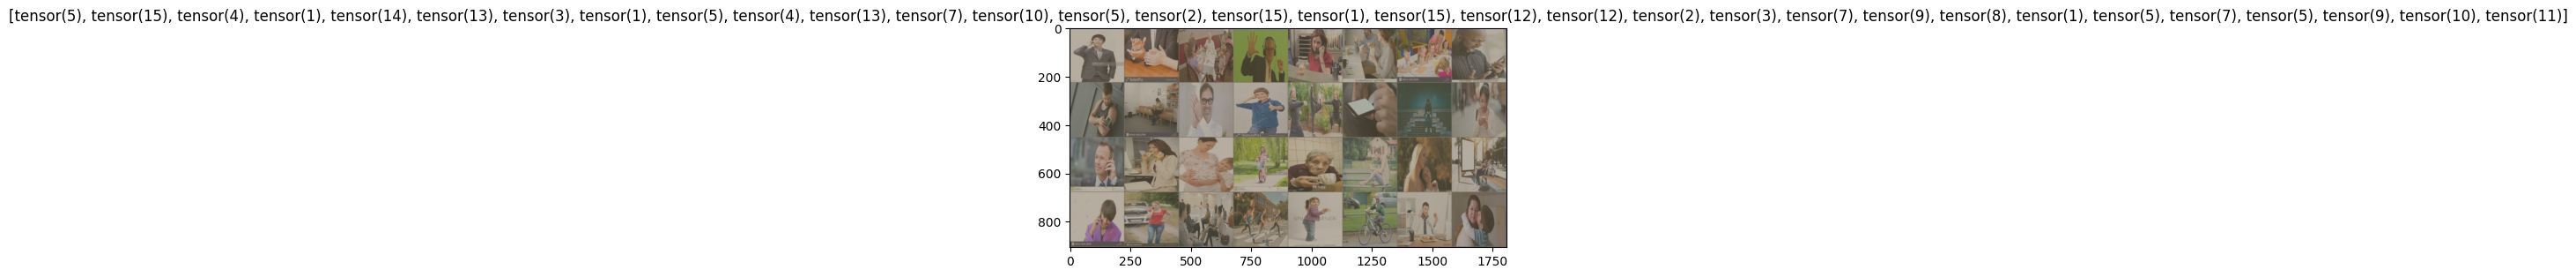

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

inputs, _, classes, = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x for x in classes])
plt.show()

This class defines a neural network clusterisator based on the ResNet18 backbone. The forward method performs inference, allowing for both clustering and overclustering regimes depending on the specified mode.

In [9]:
class ResNetClusterisator(nn.Module):
    """Clusterisator for IIC based on ResNet18 backbone"""

    def __init__(self, num_classes):
        super(ResNetClusterisator, self).__init__()
        # The number of output features we precomputed earlier
        final_features = 25088
        self.num_classes = num_classes

        # Define the backbone:
        resnet = models.resnet18(pretrained=False)
        modules = list(resnet.children())[:-2]
        modules[0] = nn.Conv2d(
            3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        modules.append(nn.Flatten())
        self.backbone = nn.Sequential(*modules)

        # Define clustering and overculstering heads
        self.cluster_head = nn.Linear(final_features, num_classes)
        self.overcluster_head = nn.Linear(final_features, 50)

        # Define the softmax layer
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, overclustering=False):
        """Foward run. Can operate in both clustering an overclustering regimes

        Paraneters
        ----------
        x : torch.tensor
            input batch. The shape is supposed to be (B,1,28,28)
            where B is batch size
        overclustering : boolean
            if True, the overclustering head is used
            else the clustering head is used
        """
        x = self.backbone(x)
        if overclustering:
            x = self.overcluster_head(x)
        else:
            x = self.cluster_head(x)

        return self.softmax(x)

Here we initialize the model, transfer it to the specified device and initialize its weights.

In [10]:
model = ResNetClusterisator(num_classes=15)
model.to(device)
print("The model is transfered to %s." % device)
model.apply(weight_init)
print("The weights are Initialised.")

c:\Users\lungd\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lungd\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The model is transfered to cuda.
The weights are Initialised.


The "compute_joint" function estimates the joint probability distribution between two sets of probability distributions, one for the original batch and the other for the transformed batch.

In [11]:
def compute_joint(x_out, x_tf_out):
    
    # multiplying probabilities
    p_i_j = x_out.unsqueeze(2) * x_tf_out.unsqueeze(1)  # bn, k, k

    # suminng over the batch_size
    p_i_j = p_i_j.mean(dim=0)

    # Symmetriztion
    p_i_j = (p_i_j + p_i_j.t()) / 2.0

    return p_i_j

The "IID_loss" function computes the mutual information loss between two sets of probability distributions, representing the original and transformed batches respectively. It takes into account a regularization parameter 'EPS' and a modification parameter 'lamb' to adjust the loss.

In [12]:
def IID_loss(x_out, x_tf_out, lamb=1.0, EPS=sys.float_info.epsilon):
    _, num_classes = x_out.size()

    # Estimate joint probabilities
    p_i_j = compute_joint(x_out, x_tf_out)
    assert p_i_j.size() == (num_classes, num_classes)

    # Trick to avoid NaN losses for small p_i_j
    mask = ((p_i_j > EPS).data).type(torch.float32)
    p_i_j = p_i_j * mask + EPS * (1 - mask)

    # Computing the marginals
    p_i = p_i_j.sum(dim=1).view(num_classes, 1).expand(num_classes, num_classes)
    p_j = p_i_j.sum(dim=0).view(1, num_classes).expand(num_classes, num_classes)

    # Compute the mutual information
    loss = -p_i_j * (torch.log(p_i_j) - lamb * torch.log(p_j) - lamb * torch.log(p_i))

    loss = torch.sum(loss)

    return loss

The "evaluate" function alculates the model mean loss with the average being taken over the batches.

In [13]:
def evaluate(
    model, dataloader, overclustering=False, lamb=1.0, device=torch.device("cpu")
):
    """Calculates the model mean loss. The average is taken over the batches."""

    losses = []
    # switch model to the eval state to prevent the training
    model.eval()

    for i, batch in enumerate(dataloader):

        # forward run
        inputs = batch[0]
        inputs_tf = batch[1]
        with torch.no_grad():

            inputs = inputs.to(device=device)
            inputs_tf = inputs_tf.to(device=device)

            outputs = model(inputs, overclustering)
            outputs_tf = model(inputs_tf, overclustering)

        loss = IID_loss(outputs, outputs_tf, lamb=lamb)

        # combining the losses for all batches into a single list
        losses.append(loss.data.cpu().numpy())

    # output the mean loss
    return np.mean(losses)

'choose_clustering_regime' selects the clustering regime based on the current epoch number, along with parameters 'overcluster_period' and 'overcluster_ratio', which determine the total period for both clustering and overclustering.

In [14]:
def choose_clustering_regime(epoch, overcluster_period, overcluster_ratio):
    if (
        overcluster_period is not None
        and epoch % overcluster_period < overcluster_period * overcluster_ratio
    ):
        return True
    else:
        return False

This function "IIC_train" is the training loop designed for the IIC model. It iterates over the dataset for 25 epochs, updating the model's parameters based on the computed loss and optimizing it using the chosen optimizer. The training process includes both clustering and overclustering stages, determined by the epoch number and provided parameters. Additionally, the function performs evaluations at specified intervals and saves the model with the best evaluation loss.

In [15]:
from tqdm.notebook import tqdm

def IIC_train(
    dataloader,
    optimizer,
    epochs=100,
    device=torch.device("cpu"),
    eval_every=5,
    lamb=1.0,
    overcluster_period=20,
    overcluster_ratio=0.5,
):

    # variable for best losses
    best_cluster_loss = 100

    start_time = datetime.datetime.now()
    start_time = start_time.strftime("%Y-%m-%d_%H-%M")

    # lists to store epochs numbers and losses
    epochs_list = []
    loss_history = []
    loss_history_overclustering = []

    # progress bar
    pbar = tqdm(total=len(dataloader), leave=False, desc="Epoch")

    for epoch in range(epochs):

        # train mode
        model.train()
        # where the epoch is dedicated to clustering or overclustering
        overclustering = choose_clustering_regime(
            epoch, overcluster_period, overcluster_ratio
        )

        # reseting the progress bar
        pbar.reset()
        pbar.desc = "Epoch #%i" % epoch

        for i, batch in enumerate(dataloader):

            # nullify the gradients
            optimizer.zero_grad()

            # forward run
            inputs = batch[0]
            inputs_tf = batch[1]

            inputs = inputs.to(device=device)
            inputs_tf = inputs_tf.to(device=device)

            outputs = model(inputs, overclustering)
            outputs_tf = model(inputs_tf, overclustering)
            loss = IID_loss(outputs, outputs_tf, lamb=lamb)

            # backward run
            loss.backward()

            # weights update
            optimizer.step()

            # updating the progreess bar
            pbar.update(1)

        # evaluation
        if (epoch + 1) % eval_every == 0:

            # eval losses
            loss_eval = evaluate(
                model, dataloader, overclustering=False, lamb=lamb, device=device
            )
            loss_eval_overclustering = evaluate(
                model, dataloader, overclustering=True, lamb=lamb, device=device
            )

            loss_history.append(loss_eval)
            loss_history_overclustering.append(loss_eval_overclustering)
            epochs_list.append(epoch)

          # save the model with best evaluation loss
            if abs(loss_eval) < abs(best_cluster_loss):
                filename = f"{start_time}_best_loss_model_epoch_{epoch}.pt"
                best_cluster_loss = loss_eval
                torch.save(model.state_dict(), filename)
            pbar.close()

            pbar = tqdm(total=len(dataloader), leave=False, desc="Epoch")
    return loss_history, loss_history_overclustering

We initialize an Adam optimizer and then call the "IIC_train" function to train the model using the provided optimizer, data loader, and training settings. It trains the model for 25 epochs and prints out the training and overclustering loss history.

In [16]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=4e-4,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0,
    amsgrad=False,
)
loss_history, loss_history_overclustering = IIC_train(
    model,
    train_loader,
    optimizer,
    device=device,
    epochs=25,
    lamb=1.2,
    overcluster_period=20,
    overcluster_ratio=0.5,
)
print(loss_history, loss_history_overclustering)


# Load the best model and test it

In [37]:
model = ResNetClusterisator(15)
model.load_state_dict(torch.load("2024-05-25_17-52_best_loss_model_epoch_9.pt"))
model.to(device)

c:\Users\lungd\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lungd\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNetClusterisator(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

The "get_cluster_labeling" function assigns cluster labels to data using a model and dataloader. It returns three lists: original labels, predicted cluster labels, and the corresponding images.

In [18]:
def get_cluster_labeling(model, dataloader, device=torch.device("cpu")):
    model.eval()
    original_labels = []
    cluster_labels = []
    images_list = []
    
    with torch.no_grad():
        for batch in dataloader:
            images = batch[0].to(device)
            labels = batch[2].to(device)
            outputs = model(images, False)
            original_labels += labels.cpu().numpy().tolist()
            cluster_labels += torch.argmax(outputs, dim=1).tolist()
            images_list += images.cpu().numpy().tolist()
    
    return original_labels, cluster_labels, images_list

In [38]:
original_labels, cluster_labels = get_cluster_labeling(
    model, test_loader, device=device
)

This code calculates the accuracy score of clustering results by comparing the original labels with the cluster labels after mapping.

In [39]:
cluster_mapping = create_mapping(original_labels, cluster_labels, {'sitting': 1, 'using_laptop': 2, 'hugging': 3, 'sleeping': 4, 'drinking': 5, 'clapping': 6, 'dancing': 7, 'cycling': 8, 'calling': 9, 'laughing': 10, 'eating': 11, 'fighting': 12, 'listening_to_music': 13, 'running': 14, 'texting': 15})
cluster_labels_mapped = [cluster_mapping[x] for x in cluster_labels]
accuracy_score(original_labels, cluster_labels_mapped)

0.1253968253968254

This code helps us visualize images from different clusters by first collecting images into a dictionary based on their predicted cluster labels, then randomly selecting and displaying 3 images from each cluster.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

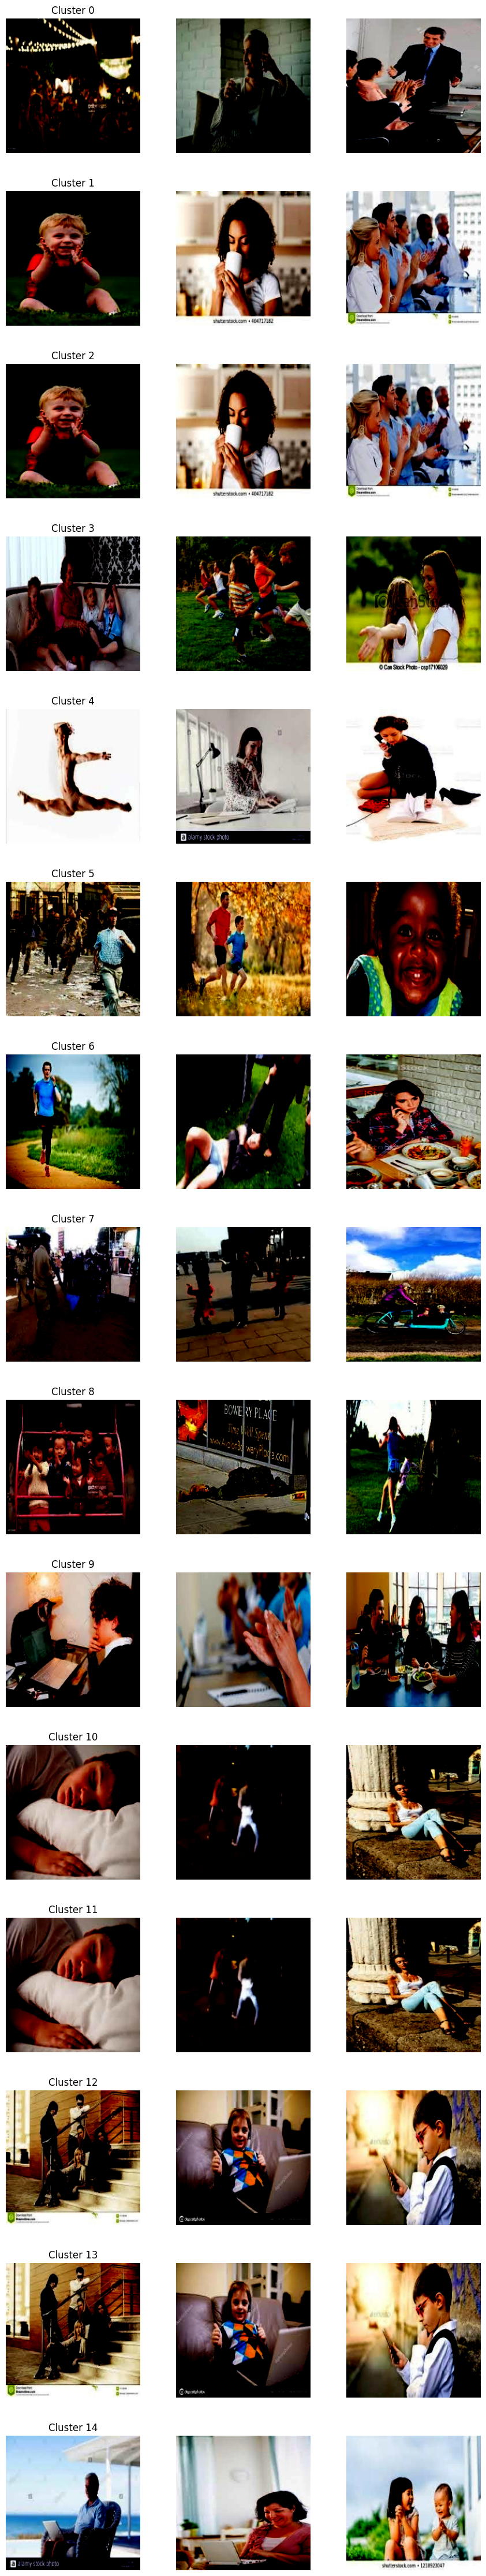

In [ ]:
import random

# display images from clusters
def display_images_from_clusters(cluster_images, num_images=3):
    fig, axes = plt.subplots(15, num_images, figsize=(num_images*3, 15*3))
    fig.tight_layout()
    
    for cluster_id, images in cluster_images.items():
        if len(images) >= num_images:
            selected_images = random.sample(images, num_images)
        
        for i, img in enumerate(selected_images):
            ax = axes[cluster_id, i]
            img = np.transpose(img.cpu().numpy(), (1, 2, 0))
            ax.imshow(img)
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Cluster {cluster_id}')
    
    plt.show()


cluster_images = {i: [] for i in range(15)} #15 classes
for batch in test_loader:
    images, _, _ = batch
    images = images.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    for img, label in zip(images, predicted):
        cluster_images[label.item()].append(img.cpu())

assert len(cluster_images) == 15, "The model did not return 15 clusters."
display_images_from_clusters(cluster_images, num_images=3)


The "visualise_clustering_results" function visualizes clustering results by showing the distribution of original labels within each cluster, using bar plots to illustrate how images with specific original labels are grouped after clustering. It creates a grid of plots, each representing a cluster, with bars indicating the count of original labels in that cluster.

In [40]:
def visualise_clustering_results(original_labels, cluster_labels, class_names, figwidth=20):
    original_labels = np.array(original_labels)
    cluster_labels = np.array(cluster_labels)
    class_ids = np.unique(cluster_labels)
    fig, axes = plt.subplots(3, 5, constrained_layout=True)
    fig.set_figwidth(figwidth)

    # Reverse the dictionary to map indices to class names
    index_to_class = {v: k for k, v in class_names.items()}
    
    class_indices = list(index_to_class.keys())
    class_labels = [index_to_class[i] for i in class_indices]

    for idx, ax in enumerate(axes.flat):
        if idx < len(class_ids):
            cluster_label = class_ids[idx]
            labels_distribution = original_labels[cluster_labels == cluster_label]
            counts = np.array([np.sum(labels_distribution == i) for i in class_indices])
            ax.bar(np.arange(len(class_indices)), counts)
            ax.set_xticks(np.arange(len(class_indices)))
            ax.set_xticklabels(class_labels, rotation=90)
            ax.set_xlim([-0.5, len(class_indices) - 0.5])
            ax.set_title("Cluster Label: %i" % cluster_label)
        else:
            ax.axis('off')



C:\Users\lungd\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
C:\Users\lungd\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


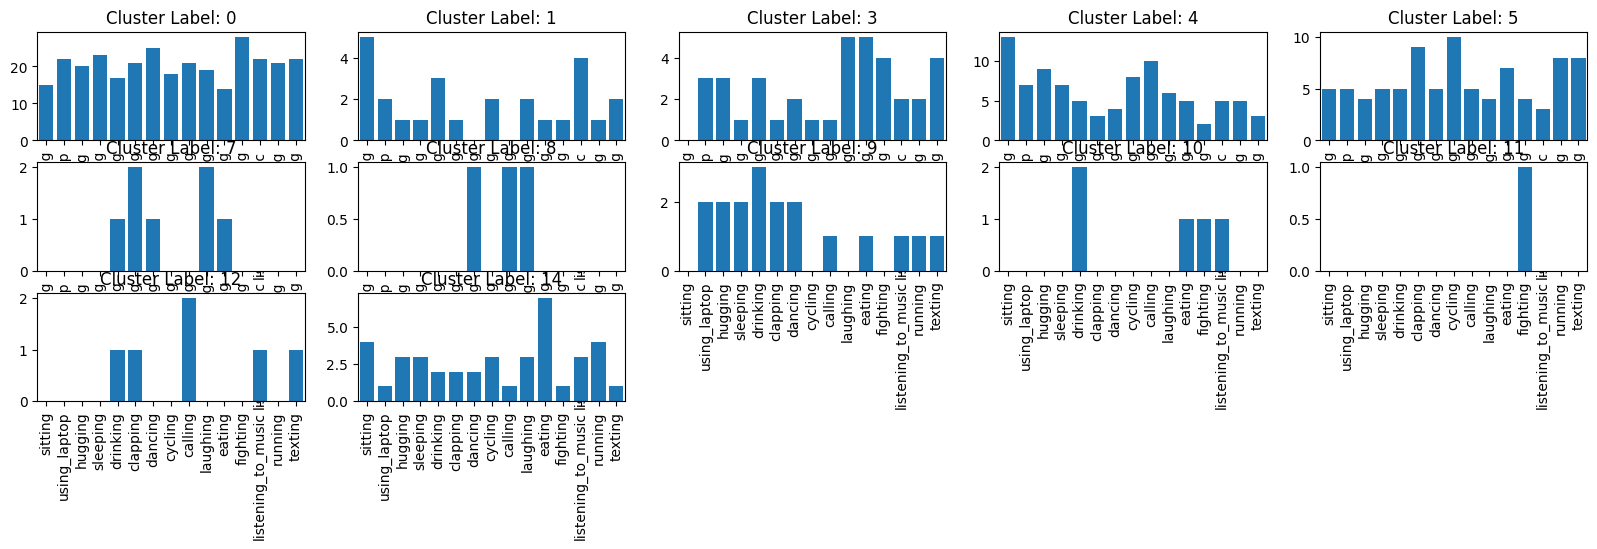

In [41]:
visualise_clustering_results(original_labels, cluster_labels, {'sitting': 1, 'using_laptop': 2, 'hugging': 3, 'sleeping': 4, 'drinking': 5, 'clapping': 6, 'dancing': 7, 'cycling': 8, 'calling': 9, 'laughing': 10, 'eating': 11, 'fighting': 12, 'listening_to_music': 13, 'running': 14, 'texting': 15})


In [42]:
cluster_mapping = create_mapping(original_labels, cluster_labels, {'sitting': 1, 'using_laptop': 2, 'hugging': 3, 'sleeping': 4, 'drinking': 5, 
                                                                   'clapping': 6, 'dancing': 7, 'cycling': 8, 'calling': 9, 'laughing': 10, 'eating': 11, 'fighting': 12, 
                                                                   'listening_to_music': 13, 'running': 14, 'texting': 15})
cluster_labels_mapped = [cluster_mapping[x] for x in cluster_labels]
print_mapping(cluster_mapping)

Cluster  Class
  0 -----> 12
  1 -----> 1
  3 -----> 10
  4 -----> 1
  5 -----> 8
  7 -----> 6
  8 -----> 7
  9 -----> 5
 10 -----> 5
 11 -----> 12
 12 -----> 9
 14 -----> 11
